In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import defaultdict

random.seed(42)
np.random.seed(42)

In [2]:
# Load CSV files
vehicles_df = pd.read_csv("vehicles.csv")
customers_df = pd.read_csv("customers.csv")

In [3]:
# Extract data
vehicle_capacities = vehicles_df['capacity'].tolist()
num_vehicles = len(vehicles_df)
vehicle_starts = [(row['start_x'], row['start_y']) for _, row in vehicles_df.iterrows()]
customer_coords = [(row['x'], row['y']) for _, row in customers_df.iterrows()]
demands = customers_df['demand'].tolist()
num_customers = len(customer_coords)
# Build distance matrix - different vehicles may start from different depots
depots = vehicle_starts
all_points = depots + customer_coords

In [4]:
def euclidean(p1, p2):
    return np.linalg.norm(np.array(p1) - np.array(p2))

distance_matrix = np.array([
    [euclidean(p1, p2) for p2 in all_points]
    for p1 in all_points
])

In [5]:
# Cost calculation function
def total_distance(solution):
    total = 0
    for i, route in enumerate(solution):
        if route:  # Only consider non-empty routes
            depot_idx = i  # Each vehicle has its own depot

            # Distance from depot to first customer
            first_cust = route[0]
            # Adjust index: depots first, then customers (0-indexed into the matrix)
            cust_idx = num_vehicles + first_cust - 1  # -1 because customer IDs are 1-indexed
            total += distance_matrix[depot_idx][cust_idx]

            # Distance between consecutive customers
            for j in range(len(route) - 1):
                cust1 = route[j]
                cust2 = route[j + 1]
                # Adjust indices for the distance matrix
                cust1_idx = num_vehicles + cust1 - 1
                cust2_idx = num_vehicles + cust2 - 1
                total += distance_matrix[cust1_idx][cust2_idx]

            # Distance from last customer back to depot
            last_cust = route[-1]
            cust_idx = num_vehicles + last_cust - 1
            total += distance_matrix[cust_idx][depot_idx]
    return total

In [6]:
# Check if a solution is feasible
def is_feasible(solution):
    # Check if all customers are assigned exactly once
    assigned_customers = [customer for route in solution for customer in route]
    if len(assigned_customers) != num_customers or len(set(assigned_customers)) != num_customers:
        return False

    # Check vehicle capacity constraints - each vehicle has its own capacity
    for i, route in enumerate(solution):
        route_demand = sum(demands[cust - 1] for cust in route)
        if route_demand > vehicle_capacities[i]:
            return False

    return True

In [7]:
# Generate initial solution
def initial_solution():
    # Use savings algorithm instead of random assignment
    customers = list(range(1, num_customers + 1))
    solution = [[] for _ in range(num_vehicles)]
    loads = [0] * num_vehicles

    # Sort customers by distance from depot (farthest first)
    customer_depot_distances = [(c, distance_matrix[c % num_vehicles][num_vehicles + c - 1])
                               for c in customers]
    sorted_customers = [c for c, _ in sorted(customer_depot_distances, key=lambda x: x[1], reverse=True)]

    # Assign customers to vehicles using best insertion
    for cust in sorted_customers:
        best_vehicle = -1
        best_cost_increase = float('inf')
        best_position = -1

        for v in range(num_vehicles):
            # Skip if adding this customer exceeds vehicle capacity
            if loads[v] + demands[cust - 1] > vehicle_capacities[v]:
                continue

            # Try to insert at every possible position
            for pos in range(len(solution[v]) + 1):
                # Calculate cost increase of insertion
                if len(solution[v]) == 0:
                    # Empty route case
                    cost_increase = 2 * distance_matrix[v][num_vehicles + cust - 1]
                elif pos == 0:
                    # Insert at beginning
                    next_cust = solution[v][0]
                    cost_increase = (distance_matrix[v][num_vehicles + cust - 1] +
                                    distance_matrix[num_vehicles + cust - 1][num_vehicles + next_cust - 1] -
                                    distance_matrix[v][num_vehicles + next_cust - 1])
                elif pos == len(solution[v]):
                    # Insert at end
                    prev_cust = solution[v][-1]
                    cost_increase = (distance_matrix[num_vehicles + prev_cust - 1][num_vehicles + cust - 1] +
                                    distance_matrix[num_vehicles + cust - 1][v] -
                                    distance_matrix[num_vehicles + prev_cust - 1][v])
                else:
                    # Insert in middle
                    prev_cust = solution[v][pos-1]
                    next_cust = solution[v][pos]
                    cost_increase = (distance_matrix[num_vehicles + prev_cust - 1][num_vehicles + cust - 1] +
                                    distance_matrix[num_vehicles + cust - 1][num_vehicles + next_cust - 1] -
                                    distance_matrix[num_vehicles + prev_cust - 1][num_vehicles + next_cust - 1])

                if cost_increase < best_cost_increase:
                    best_cost_increase = cost_increase
                    best_vehicle = v
                    best_position = pos

        if best_vehicle != -1:
            solution[best_vehicle].insert(best_position, cust)
            loads[best_vehicle] += demands[cust - 1]
        else:
            # Fallback strategy if no feasible insertion was found
            min_overload_vehicle = min(range(num_vehicles),
                                      key=lambda v: loads[v]/vehicle_capacities[v])
            solution[min_overload_vehicle].append(cust)
            loads[min_overload_vehicle] += demands[cust - 1]

    return solution

In [8]:
# Generate a neighbor solution
def get_neighbor(solution):
    new_solution = [route[:] for route in solution]

    # Weighted selection of move types (favoring more effective moves)
    move_types = ["swap", "relocate", "2opt", "cross_exchange", "or_opt"]
    move_weights = [0.2, 0.3, 0.25, 0.15, 0.1]  # Adjust based on effectiveness
    move_type = random.choices(move_types, weights=move_weights)[0]

    if move_type == "swap" and num_vehicles > 1:
        # Existing swap logic, but with smarter selection
        routes_with_customers = [i for i in range(num_vehicles) if new_solution[i]]
        if len(routes_with_customers) >= 2:
            i, j = random.sample(routes_with_customers, 2)
            a = random.randint(0, len(new_solution[i]) - 1)
            b = random.randint(0, len(new_solution[j]) - 1)

            # Check capacity constraints before swapping
            cust_i = new_solution[i][a]
            cust_j = new_solution[j][b]
            route_i_demand = sum(demands[c-1] for c in new_solution[i]) - demands[cust_i-1] + demands[cust_j-1]
            route_j_demand = sum(demands[c-1] for c in new_solution[j]) - demands[cust_j-1] + demands[cust_i-1]

            if (route_i_demand <= vehicle_capacities[i] and
                route_j_demand <= vehicle_capacities[j]):
                new_solution[i][a], new_solution[j][b] = new_solution[j][b], new_solution[i][a]

    elif move_type == "relocate":
        # Relocate with better selection of source and destination
        non_empty_routes = [i for i in range(num_vehicles) if new_solution[i]]
        if non_empty_routes:
            i = random.choice(non_empty_routes)
            possible_destinations = [j for j in range(num_vehicles) if j != i]

            if possible_destinations and new_solution[i]:
                j = random.choice(possible_destinations)
                a = random.randint(0, len(new_solution[i]) - 1)
                customer = new_solution[i][a]

                # Check capacity constraint
                if sum(demands[c-1] for c in new_solution[j]) + demands[customer-1] <= vehicle_capacities[j]:
                    customer = new_solution[i].pop(a)
                    # Find best insertion point (greedy)
                    best_pos = 0
                    best_cost = float('inf')

                    for pos in range(len(new_solution[j]) + 1):
                        # Calculate insertion cost
                        new_sol = [r[:] for r in new_solution]
                        new_sol[j].insert(pos, customer)
                        cost = total_distance(new_sol)

                        if cost < best_cost:
                            best_cost = cost
                            best_pos = pos

                    new_solution[j].insert(best_pos, customer)

    elif move_type == "2opt":
        # 2-opt with route selection proportional to route length
        route_lengths = [len(route) for route in new_solution]
        if sum(route_lengths) > 0:
            i = random.choices(range(num_vehicles),
                              weights=[max(1, len(route)) for route in new_solution])[0]
            if len(new_solution[i]) >= 2:
                a = random.randint(0, len(new_solution[i]) - 2)
                b = random.randint(a + 1, len(new_solution[i]) - 1)
                new_solution[i][a:b+1] = reversed(new_solution[i][a:b+1])

    elif move_type == "cross_exchange" and num_vehicles > 1:
        # Exchange segments between two routes
        routes_with_customers = [i for i in range(num_vehicles) if len(new_solution[i]) >= 2]
        if len(routes_with_customers) >= 2:
            i, j = random.sample(routes_with_customers, 2)

            # Select segments
            a1 = random.randint(0, len(new_solution[i]) - 2)
            a2 = random.randint(a1 + 1, min(len(new_solution[i]) - 1, a1 + 3))  # Limit segment size

            b1 = random.randint(0, len(new_solution[j]) - 2)
            b2 = random.randint(b1 + 1, min(len(new_solution[j]) - 1, b1 + 3))  # Limit segment size

            # Check capacity constraints
            segment_i = new_solution[i][a1:a2+1]
            segment_j = new_solution[j][b1:b2+1]

            demand_i_without = sum(demands[c-1] for c in new_solution[i] if c not in segment_i)
            demand_j_without = sum(demands[c-1] for c in new_solution[j] if c not in segment_j)

            demand_i_new = demand_i_without + sum(demands[c-1] for c in segment_j)
            demand_j_new = demand_j_without + sum(demands[c-1] for c in segment_i)

            if (demand_i_new <= vehicle_capacities[i] and
                demand_j_new <= vehicle_capacities[j]):
                # Extract segments
                segment_i = new_solution[i][a1:a2+1]
                segment_j = new_solution[j][b1:b2+1]

                # Replace segments
                new_solution[i] = new_solution[i][:a1] + segment_j + new_solution[i][a2+1:]
                new_solution[j] = new_solution[j][:b1] + segment_i + new_solution[j][b2+1:]

    elif move_type == "or_opt":
        # Or-opt: move a sequence of 1-3 consecutive customers to another position
        non_empty_routes = [i for i in range(num_vehicles) if len(new_solution[i]) >= 3]
        if non_empty_routes:
            i = random.choice(non_empty_routes)
            # Select sequence length
            seq_len = random.randint(1, min(3, len(new_solution[i])-1))
            # Select start position
            start_pos = random.randint(0, len(new_solution[i]) - seq_len)
            # Select target position (can be in same or different route)
            if random.random() < 0.7 or num_vehicles == 1:  # 70% same route
                j = i
                # Target position excluding original sequence
                valid_positions = list(range(0, start_pos)) + list(range(start_pos + seq_len, len(new_solution[i]) + 1))
                if valid_positions:
                    target_pos = random.choice(valid_positions)
                    # Extract sequence
                    sequence = new_solution[i][start_pos:start_pos+seq_len]
                    # Remove sequence
                    new_solution[i] = new_solution[i][:start_pos] + new_solution[i][start_pos+seq_len:]
                    # Insert at target position
                    if target_pos > start_pos:
                        target_pos -= seq_len  # Adjust for removal
                    new_solution[i][target_pos:target_pos] = sequence
            else:  # 30% different route
                other_routes = [k for k in range(num_vehicles) if k != i]
                if other_routes:
                    j = random.choice(other_routes)
                    sequence = new_solution[i][start_pos:start_pos+seq_len]
                    # Check capacity
                    seq_demand = sum(demands[c-1] for c in sequence)
                    if sum(demands[c-1] for c in new_solution[j]) + seq_demand <= vehicle_capacities[j]:
                        target_pos = random.randint(0, len(new_solution[j]))
                        # Remove sequence from route i
                        new_solution[i] = new_solution[i][:start_pos] + new_solution[i][start_pos+seq_len:]
                        # Insert at target position in route j
                        new_solution[j][target_pos:target_pos] = sequence

    return new_solution

In [9]:
# Simulated Annealing
def simulated_annealing(initial_T, alpha_start, alpha_end, stop_T, max_iter):
    current_solution = initial_solution()
    best_solution = [route[:] for route in current_solution]

    current_cost = total_distance(current_solution)
    best_cost = current_cost

    T = initial_T
    iteration = 0
    no_improvement_count = 0
    temperatures = []
    costs = [current_cost]
    best_costs = [best_cost]  # Track best cost over time
    iterations = [0]  # Track iteration numbers

    # Dynamic alpha adjustment
    alpha = alpha_start

    while T > stop_T:
        improved_in_inner_loop = False

        for _ in range(max_iter):
            neighbor = get_neighbor(current_solution)

            # Limit attempts to find feasible solution
            attempts = 0
            while not is_feasible(neighbor) and attempts < 20:
                neighbor = get_neighbor(current_solution)
                attempts += 1

            if is_feasible(neighbor):
                neighbor_cost = total_distance(neighbor)
                delta = neighbor_cost - current_cost

                # Accept the new solution if it's better or with a probability based on temperature
                acceptance_probability = np.exp(-delta / T) if delta > 0 else 1.0
                if delta < 0 or random.random() < acceptance_probability:
                    current_solution = [route[:] for route in neighbor]
                    current_cost = neighbor_cost

                    # Update the best solution if we found a better one
                    if current_cost < best_cost:
                        best_solution = [route[:] for route in current_solution]
                        best_cost = current_cost
                        improved_in_inner_loop = True
                        no_improvement_count = 0

                        # Track the best cost and iteration
                        # best_costs.append(best_cost)

        # Record data for plotting
        temperatures.append(T)
        costs.append(current_cost)  # Track current cost at each temperature step
        best_costs.append(best_cost)
        iterations.append(iteration)
        # Adaptive cooling rate based on improvement
        if not improved_in_inner_loop:
            no_improvement_count += 1
            # If no improvement for several iterations, cool faster
            if no_improvement_count > 5:
                alpha = min(alpha_end, alpha * 1.02)  # Cool faster
        else:
            # If improvement was found, cool slower
            alpha = max(alpha_start, alpha * 0.98)  # Cool slower

        # Cool down
        T *= alpha
        iteration += 1

        # Print progress
        if iteration % 10 == 0:
            # print(f"Iteration {iteration}, Temperature: {T:.4f}, Alpha: {alpha:.6f}, Best cost: {best_cost:.2f}")
            pass
        # Reheating mechanism
        if no_improvement_count > 20:
            # print(f"Reheating at iteration {iteration}")
            T = T * 10  # Reheat
            no_improvement_count = 0

    # Store convergence data for plotting
    convergence_data = {
        'temperatures': temperatures,
        'costs': costs,
        'best_costs': best_costs,
        'iterations': iterations
    }

    return best_solution, best_cost, convergence_data

In [10]:
def solve_vrp(initial_T=1000, alpha_start=0.7, alpha_end=0.8, stop_T=1e-3, max_iter=1000):
    """Complete VRP solution with pre and post processing"""
    # Step 1: Generate initial solution
    initial_sol = initial_solution()
    initial_cost = total_distance(initial_sol)
    print(f"Initial solution cost: {initial_cost:.2f}")

    # Step 2: Run adaptive simulated annealing
    sa_solution, sa_cost, convergence_data = simulated_annealing(initial_T,alpha_start,alpha_end,stop_T,max_iter)
    print(f"After simulated annealing cost: {sa_cost:.2f}")

    # Plot convergence data
    # plot_convergence(convergence_data)


    return sa_solution, sa_cost, convergence_data

In [11]:
def plot_convergence_and_solution(
    convergence_data,
    solution,
    cost,
):
    """Plot both simulated annealing convergence and VRP solution side by side"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # === Plot 1: Convergence ===
    ax1_twin = ax1.twinx()

    # Plot temperature cooling schedule
    ax1.plot(convergence_data['temperatures'], 'r-', linewidth=2, label='Temperature')
    ax1.set_yscale('log')
    ax1.set_ylabel('Temperature (log scale)', fontsize=10, color='r')
    ax1.tick_params(axis='y', labelcolor='r')
    ax1.set_xlabel('Iteration', fontsize=10)
    ax1.set_title('Simulated Annealing Convergence', fontsize=12)
    ax1.grid(True)

    # Plot cost vs best cost over iterations on secondary y-axis
    ax1_twin.plot(convergence_data['best_costs'], 'g--', label='Best Cost', alpha=0.7)
    ax1_twin.plot(convergence_data['costs'], 'b-', label='Current Cost', alpha=0.9)
    ax1_twin.set_ylabel('Solution Cost', fontsize=10)
    ax1_twin.legend(loc='upper right')

    # === Plot 2: VRP Solution ===
    ax2.set_title(f'VRP Solution - Total Distance: {cost:.2f}', fontsize=12)

    colors = ['g', 'c', 'm', 'y', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive']
    route_stats = []

    # Plot depots
    for i in range(num_vehicles):
        ax2.scatter(depots[i][0], depots[i][1], c='red', s=200, marker='s')
        ax2.annotate(f'D{i+1}', (depots[i][0], depots[i][1]), xytext=(5, 5),
                     textcoords='offset points', fontsize=10, weight='bold')

    # Plot customers
    for i, (x, y) in enumerate(customer_coords):
        customer_id = i + 1
        demand = demands[i]
        ax2.scatter(x, y, c='blue', s=100)
        ax2.annotate(f'C{customer_id}\n({demand})', (x, y),
                     xytext=(5, 5), textcoords='offset points', fontsize=8)

    # Plot routes
    for i, route in enumerate(solution):
        if route:
            color = colors[i % len(colors)]
            route_demand = sum(demands[cust - 1] for cust in route)
            capacity_utilization = route_demand / vehicle_capacities[i] * 100
            route_dist = 0

            x1, y1 = depots[i]
            first_cust = route[0]
            x2, y2 = customer_coords[first_cust - 1]
            ax2.plot([x1, x2], [y1, y2], c=color, linewidth=2)
            route_dist += distance_matrix[i][num_vehicles + first_cust - 1]

            for j in range(len(route) - 1):
                cust1 = route[j]
                cust2 = route[j + 1]
                x1, y1 = customer_coords[cust1 - 1]
                x2, y2 = customer_coords[cust2 - 1]
                ax2.plot([x1, x2], [y1, y2], c=color, linewidth=2)
                route_dist += distance_matrix[num_vehicles + cust1 - 1][num_vehicles + cust2 - 1]

            last_cust = route[-1]
            x1, y1 = customer_coords[last_cust - 1]
            x2, y2 = depots[i]
            ax2.plot([x1, x2], [y1, y2], c=color, linewidth=2, linestyle='--')
            route_dist += distance_matrix[num_vehicles + last_cust - 1][i]

            route_stats.append({
                'Vehicle': i+1,
                'Customers': len(route),
                'Load': route_demand,
                'Capacity': vehicle_capacities[i],
                'Utilization': f"{capacity_utilization:.1f}%",
                'Distance': f"{route_dist:.2f}"
            })

            ax2.text(depots[i][0] + 2, depots[i][1] + 2,
                     f"V{i+1}: {len(route)} cust, {route_dist:.1f} dist",
                     color=color, fontsize=8, weight='bold',
                     bbox=dict(facecolor='white', alpha=0.7))

    ax2.grid(True)

    # Add a summary table below the plot
    fig.subplots_adjust(bottom=0.25)
    fig.text(0.5, 0.02,
             "\n".join([
                 f"Vehicle {s['Vehicle']}: {s['Customers']} customers, "
                 f"Load {s['Load']}/{s['Capacity']} ({s['Utilization']}), "
                 f"Distance {s['Distance']}"
                 for s in route_stats
             ]),
             ha="center", fontsize=9,
             bbox={"facecolor": "lightgray", "alpha": 0.5, "pad": 5})

    plt.tight_layout(rect=[0, 0.1, 1, 1])
    plt.show()

    return route_stats

Initial solution cost: 160.39
After simulated annealing cost: 160.39


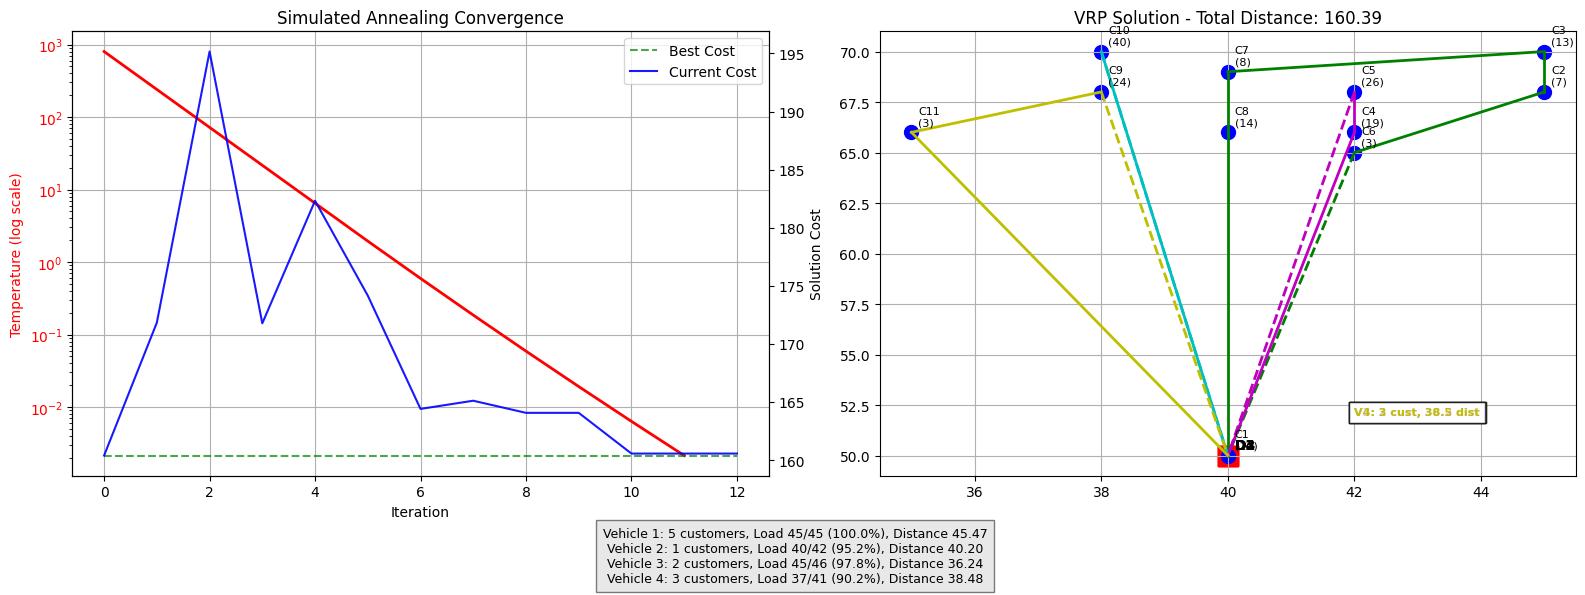

Initial solution cost: 160.39
After simulated annealing cost: 158.33


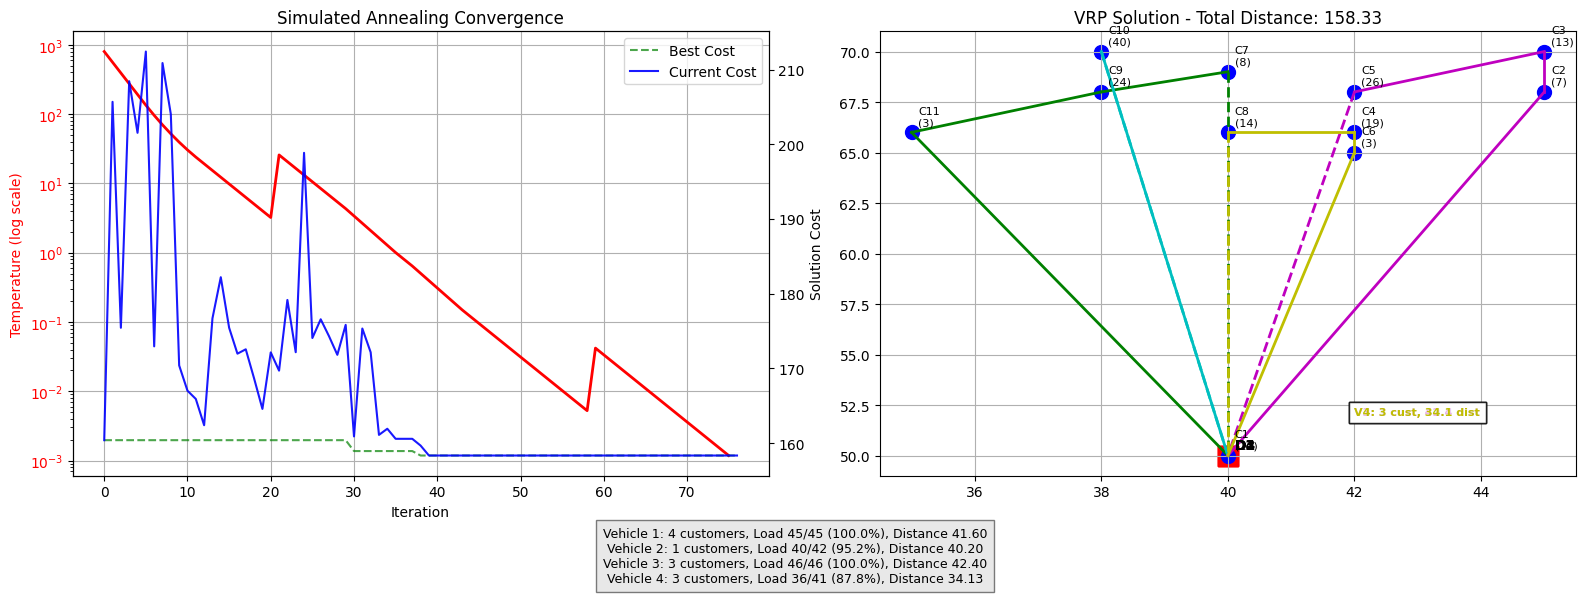

Initial solution cost: 160.39
After simulated annealing cost: 158.33


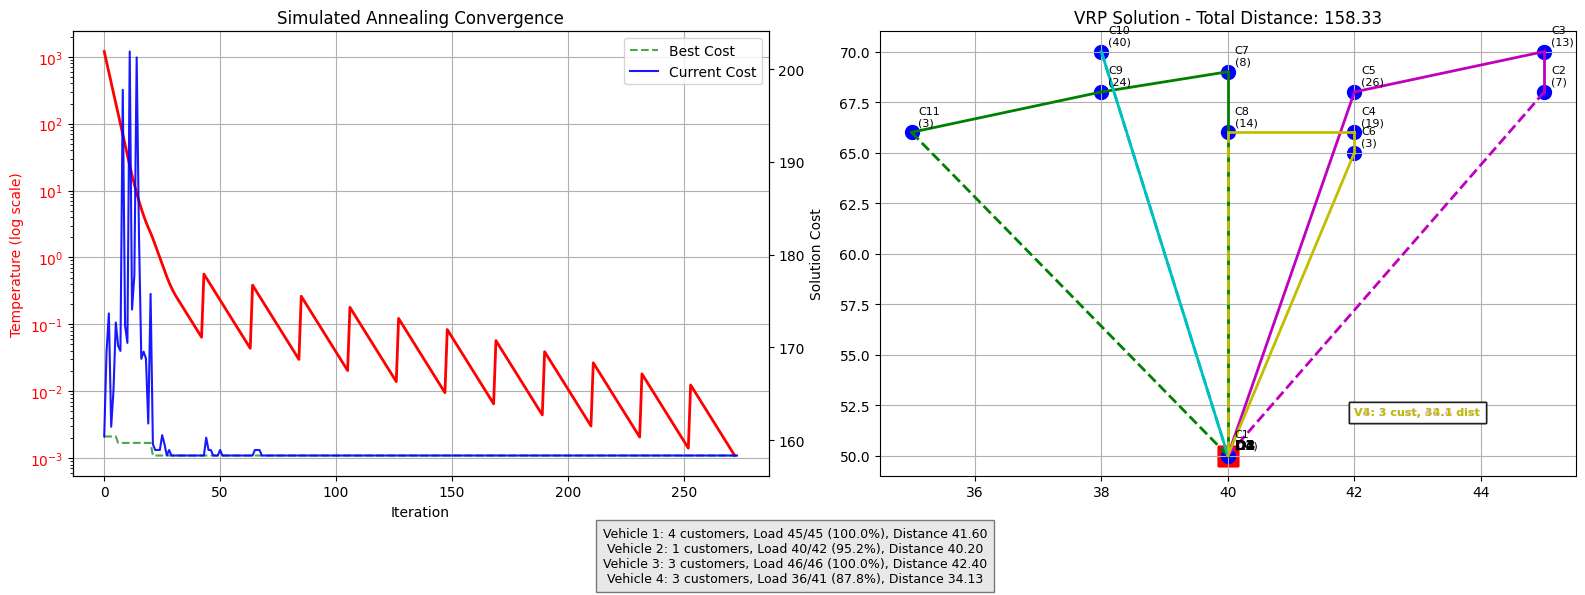

Initial solution cost: 160.39
After simulated annealing cost: 158.33


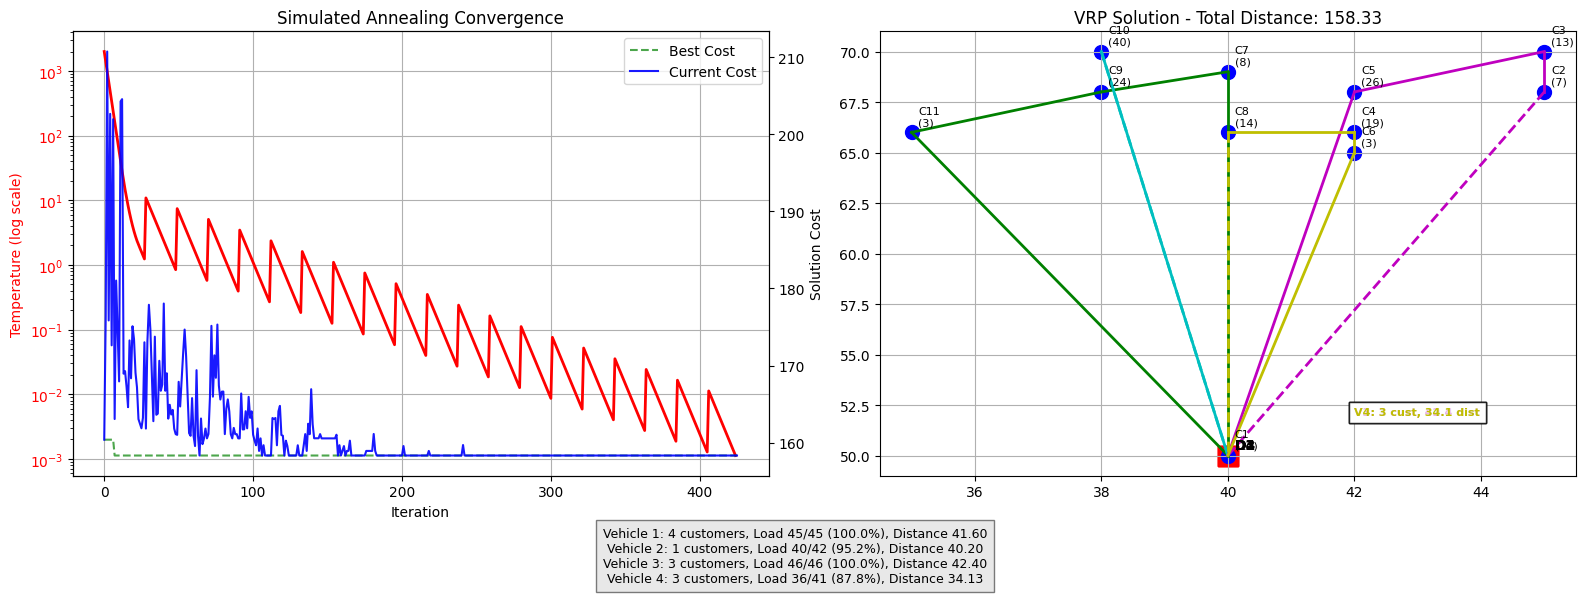

Initial solution cost: 160.39
After simulated annealing cost: 158.33


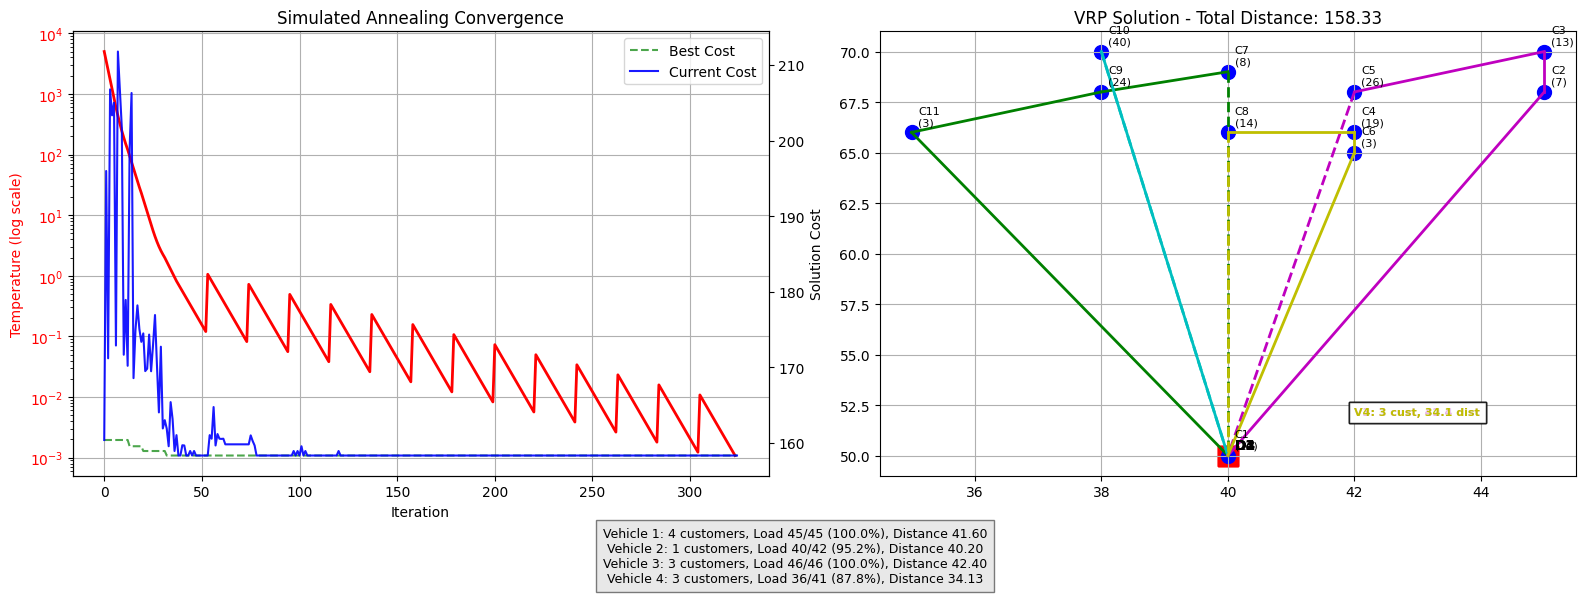

In [13]:
parameters = [
     {"initial_T" : 800,
     "alpha_start" : 0.3,
     "alpha_end" : 0.5,
     "stop_T" : 1e-3,
     "max_iter" : 200
     },
    {"initial_T" : 800,
     "alpha_start" : 0.7,
     "alpha_end" : 0.8,
     "stop_T" : 1e-3,
     "max_iter" : 600
     },
    {"initial_T" : 1200,
     "alpha_start" : 0.7,
     "alpha_end" : 0.88,
     "stop_T" : 1e-3,
     "max_iter" : 800
     },

     {"initial_T" : 2000,
     "alpha_start" : 0.7,
     "alpha_end" : 0.88,
     "stop_T" : 1e-3,
     "max_iter" : 1500
     },

     {"initial_T" : 5000,
     "alpha_start" : 0.7,
     "alpha_end" : 0.88,
     "stop_T" : 1e-3,
     "max_iter" : 2500
     },

]

solutions_costs = []

for param in parameters:
    initial_T = param["initial_T"]
    alpha_start = param["alpha_start"]
    alpha_end = param["alpha_end"]
    stop_T = param["stop_T"]
    max_iter = param["max_iter"]
    solution, cost, convergence_data = solve_vrp(initial_T,alpha_start,alpha_end,stop_T,max_iter)
    # solutions_costs.append((solution, cost))
    plot_convergence_and_solution(convergence_data, solution, cost)


# for solution, cost in solutions_costs:

#     visualize_solution(solution, cost)